<a href="https://colab.research.google.com/github/scardenol/proc_est2/blob/main/P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
# Se corre una vez al abrir una nueva sesión
# !pip install yfinance
# !pip install fitter
# !pip install pingouin
# !pip install hurst

In [45]:
import numpy as np
import random as rnd

import pandas as pd
import pingouin as pg
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from fitter import Fitter, get_common_distributions, get_distributions
import pylab 
import scipy.stats as stats
from scipy.stats import shapiro, normaltest, anderson, kstest, chisquare
import warnings
warnings.filterwarnings("ignore")
from hurst import compute_Hc
from IPython.display import display, Math

import matplotlib.pyplot as plt # gráficas
import matplotlib as mpl
from matplotlib import rc
import matplotlib.pylab as plt

import seaborn as sns # gráficas
plt.style.use('ggplot') # estilo de gráficas

# Pronóstico 1: EDEL Homogénea

\begin{equation}
  dX_t = F(t)X_tdt + G(t)X_tdB_t, \quad X_{t_0} = X_0
\end{equation}

definida sobre $[t_0, T]$, donde ${F,G}$ son funciones deterministas continuas de valores en $\mathbb{R}$ y $\{B_t\}_{t \geq 0}$ es un MBEU. Su solución es

\begin{equation}
  X_t = X_0 \exp\Bigg[{\int_{t_0}^t}\bigg(F(s)-\frac{1}{2}G(s)^2\bigg)ds + \int_{t_0}^t G(s) dB_s \Bigg]
\end{equation}

## 2. Simulación


En este caso $F(t)=\mu$ y $G(t)=\sigma$, con $\mu \in [0,1]$ y $\sigma \in [0,0.4]$. Entonces se tiene la EDE homogénea 

\begin{equation}
  dX_t = \mu X_tdt + \sigma X_tdB_t
\end{equation}

con solución

\begin{equation}
  X_t = X_0 \exp\Bigg[{\int_{t_0}^t}\bigg(\mu-\frac{1}{2}\sigma^2\bigg)ds + \int_{t_0}^t \sigma dB_s \Bigg]
\end{equation}

Al aproximar numéricamente por Euler-Maruyama
\begin{equation}
  X(t) = X(t-1) \exp\Bigg[\bigg(\mu - \frac{1}{2}\sigma^2\bigg)\Delta t + \sigma \Delta B_t\Bigg], \quad X(0) = 1
\end{equation}

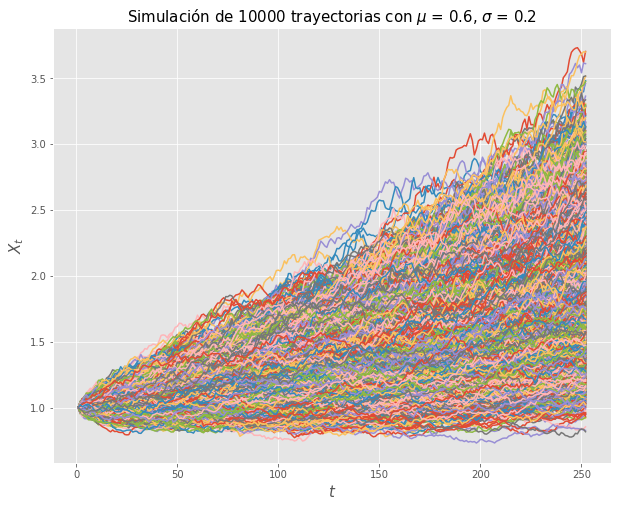

In [46]:
# EDEL Homogénea
l = 10000 # número de simulaciones
p = 252 # número de observaciones

X = np.zeros((l,p))
dt = 1/p # Delta de t de la solución discreta
T = np.linspace(dt, 1, p) # Intervalo equiespaciado en [0,1]
X0 = 1 # Valor inicial
mu = 0.6
sigma = 0.2

plt.figure(figsize=(10,8))
for sim in range(l): # Ciclo de simulaciones
  X[sim,0] = X0
  for t in range(1, p): # Ciclo de observaciones
    dBt = np.sqrt(dt)*np.random.normal(0,1) # Delta de Bt de la sol. discreta
    # Solución discreta
    X[sim, t] = X[sim, t-1]*np.exp((mu-0.5*sigma**2)*dt + sigma*dBt)
  plt.plot(p*T, X[sim]);

title = 'Simulación de ' + str(l) + ' trayectorias con $\mu$ = ' + str(mu) + ', $\sigma$ = ' + str(sigma)
plt.title(title, fontsize = 15);
plt.xlabel('$t$', fontsize = 15);
plt.ylabel('$X_t$', fontsize = 15);

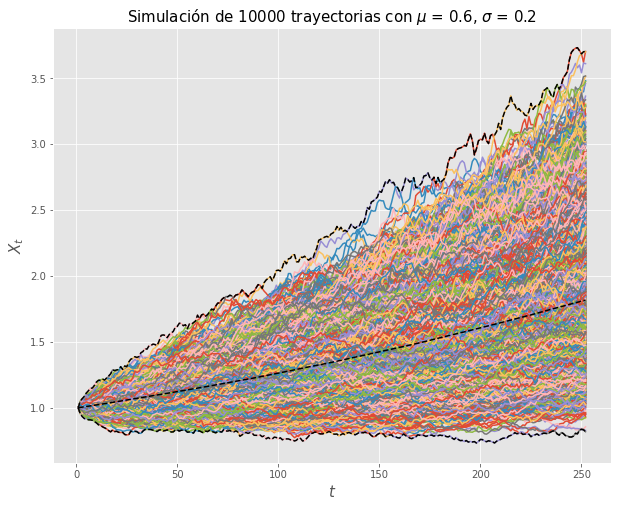

In [47]:
# Análisis longitudinal
X_max = np.amax(X, axis=0) # Trayectoria máxima
X_min = np.amin(X, axis=0) # Trayectoria mínima
X_mean = np.mean(X, axis=0) # Trayectoria promedio

plt.figure(figsize=(10,8))
[plt.plot(p*T, X[_]) for _ in range(l)];

plt.plot(p*T, X_max, '--', color='black');
plt.plot(p*T, X_min, '--', color='black');
plt.plot(p*T, X_mean, '--', color='black');

title = 'Simulación de ' + str(l) + ' trayectorias con $\mu$ = ' + str(mu) + ', $\sigma$ = ' + str(sigma)
plt.title(title, fontsize = 15);
plt.xlabel('$t$', fontsize = 15);
plt.ylabel('$X_t$', fontsize = 15);

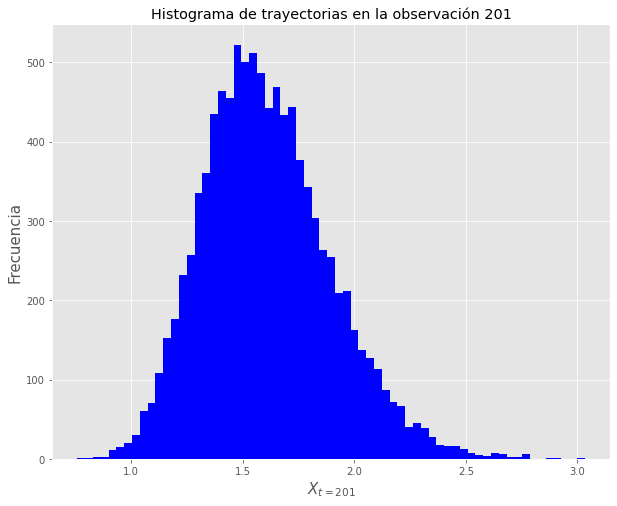

In [48]:
# Análisis transversal
X_tra = X[:, 200]

plt.figure(figsize=(10,8))
_ = plt.hist(X_tra, bins='auto', color='blue')
plt.title('Histograma de trayectorias en la observación 201');
plt.xlabel('$X_{t=201}$', fontsize = 15);
plt.ylabel('Frecuencia', fontsize = 15);

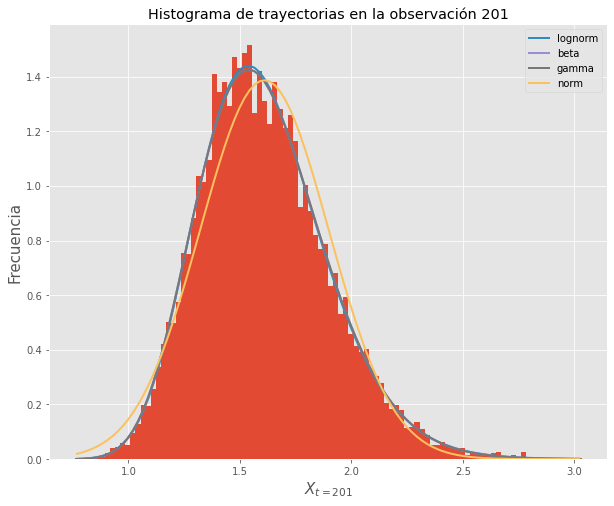

In [49]:
# Ajuste a varias distribuciones
plt.figure(figsize=(10,8))
f = Fitter(X_tra, distributions=['lognorm', 'gamma', 'beta', 'norm'])
f.fit()
f.summary()

plt.title('Histograma de trayectorias en la observación 201');
plt.xlabel('$X_{t=201}$', fontsize = 15);
plt.ylabel('Frecuencia', fontsize = 15);

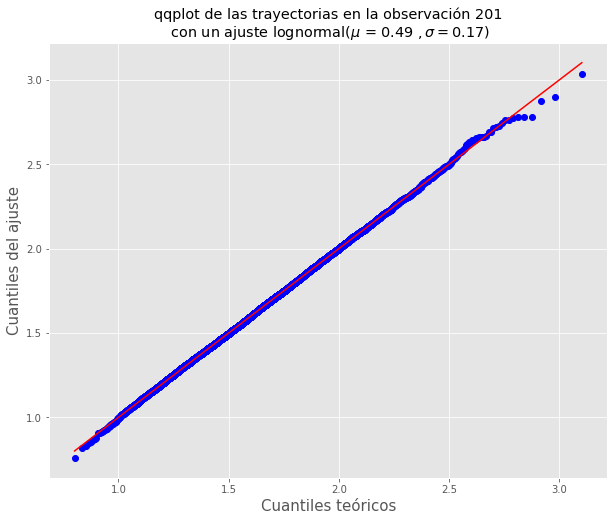

In [50]:
# QQplot respecto a una lognormal
params = f.fitted_param["lognorm"]
sigma_hat = str(round(params[0],2))
mu_hat = str(round(np.log(params[2]), 2))

plt.figure(figsize=(10,8))
stats.probplot(X_tra, dist=stats.lognorm, sparams=params, plot=pylab);

title = 'qqplot de las trayectorias en la observación 201\n con un ajuste \
lognormal($\mu$ = ' + mu_hat + ' $,\sigma = $' + sigma_hat + ')'
plt.title(title);
plt.xlabel('Cuantiles teóricos', fontsize = 15);
plt.ylabel('Cuantiles del ajuste', fontsize = 15);

In [51]:
# Autocorrelación parcial PACF
import pandas as pd
from statsmodels.tsa.stattools import pacf
df = pd.DataFrame(X)
df_pacf = pd.DataFrame([pacf(df.iloc[i,:].to_numpy()) for i in range(l)])

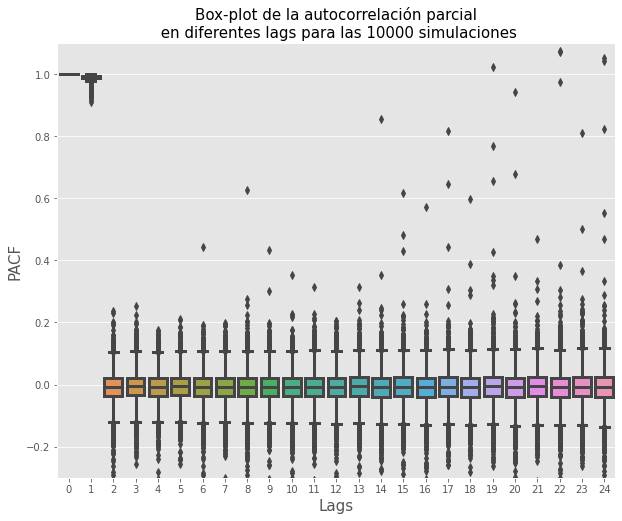

In [52]:
# Visualizar
plt.figure(figsize = (10, 8));

sns.boxplot(data = df_pacf, linewidth = 3);
plt.xlabel('Lags', fontsize = 15);
plt.ylabel('PACF', fontsize = 15);

title = 'Box-plot de la autocorrelación parcial\n en diferentes lags para las '\
         + str(l) + ' simulaciones'
plt.title(title, fontsize = 15);
plt.ylim([-0.3, 1.1]);

In [53]:
# Condiciones a nivel de distribución

def test_normalidad(data):

  if data.shape[1] > 1: # Multivariado
    norm = data.agg(normaltest).iloc[1,:] # H0: normal
    shap = data.agg(shapiro).iloc[1,:] # H0: normal, Skweness & Kurtosis
    ande = data.agg(anderson) # H0: normal
    ande_cv = ande.iloc[1][0][2]
    ande = ande.iloc[0]

    norm = norm[norm > 0.05].count()
    shap = shap[shap > 0.05].count()
    ande = ande[ande < ande_cv].count()
    resul_uni = 100*np.array([norm/l, shap/l, ande/l])

  else: # Univariado
    
    norm = data.agg(normaltest)
    shap = data.agg(shapiro)
    ande = data.agg(anderson)
    ande_cv = ande.iloc[1][0][2]
    ande = ande.iloc[0]

    norm = list(norm.iloc[1] > 0.5)[0]
    shap = list(shap.iloc[1] > 0.5)[0]
    ande = list(ande < ande_cv)[0]
    resul_uni = [norm, shap, ande]
  
  tests_uni = ['K^2', 'Shapiro', 'Anderson-Darling']

  if data.shape[1] > 1: # Multivariado

    count1 = 0
    for i in range(200):
      r = pg.multivariate_normality(data.iloc[:,0+50*i:50*(i+1)], alpha=.05)
      if r.normal:
        count1 += r.normal

    count2 = 0
    for i in range(2000):
      r = pg.multivariate_normality(data.iloc[:,0+5*i:5*(i+1)], alpha=.05)
      if r.normal:
        count2 += r.normal
    
    resul = np.append(resul_uni, 100*np.array([count1/200, count2/2000]))
    tests = tests_uni + ['HZ(200*50)', 'HZ(2000*5)']
    text = 'Éxito (%)'
  
  else: # Univariado
    resul = resul_uni 
    tests = tests_uni
    text = 'Éxito'

  r = pd.DataFrame({'Test':tests, text:resul})
  return r

In [54]:
df = pd.DataFrame(X) # Datos como dataframe
rendimientos =  np.log(df.T).diff().dropna()
r = test_normalidad(rendimientos)
r

,Test,Éxito (%)
0,K^2,94.79
1,Shapiro,95.04
2,Anderson-Darling,95.55
3,HZ(200*50),99.00
4,HZ(2000*5),95.30


In [55]:
H_mean = 0
H_min = 0
H_max = 0

H_mean, _, _ = compute_Hc(X_mean)
H_min, _, _ = compute_Hc(X_min)
H_max, _, _ = compute_Hc(X_max)

print('H_mean = ' + str(round(H_mean, 2)))
print('H_min = ' + str(round(H_min, 2)))
print('H_max = ' + str(round(H_max, 2)))

H_mean = 0.62
H_min = 0.64
H_max = 0.93


## Esperanza y Varianza a largo plazo

La esperanza y varianza teóricas son

\begin{equation}
  \mathbb{E}[X_t] = X_0 e^{\mu t}
\end{equation}


\begin{equation}
  \mathbb{V}[X_t] = X_0^2 e^{2\mu t}\bigg(e^{\sigma^2t}-1\bigg)
\end{equation}

donde en este caso $X_0 = 1$

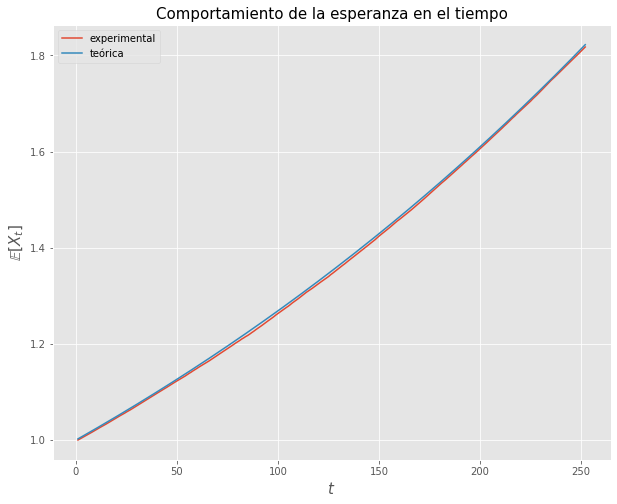

In [56]:
# Esperanza y Varianza de largo plazo

plt.figure(figsize=(10,8))
plt.plot(p*T, X_mean)
plt.plot(p*T, X0*np.exp(mu*T))
plt.legend(['experimental', 'teórica']);

plt.xlabel('$t$', fontsize = 15);
plt.ylabel('$\mathbb{E}[X_t]$', fontsize = 15);
plt.title('Comportamiento de la esperanza en el tiempo', fontsize = 15);

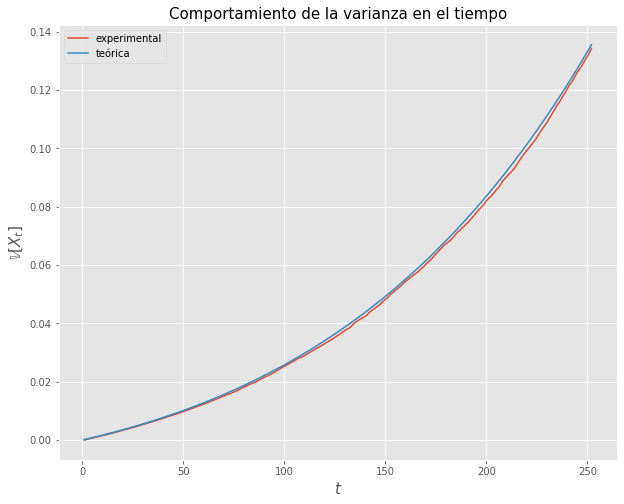

In [57]:
X_var = np.var(X, axis=0)

plt.figure(figsize=(10,8))
plt.plot(p*T, X_var)
plt.plot(p*T, (X0**2)*np.exp(2*mu*T)*(np.exp((sigma**2)*T)-1))
plt.xlabel('$t$', fontsize = 15);
plt.ylabel('$\mathbb{V}[X_t]$', fontsize = 15);
plt.title('Comportamiento de la varianza en el tiempo', fontsize = 15);
plt.legend(['experimental', 'teórica']);

## 3. Selección de una acción financiera caracterizada por la EDEL

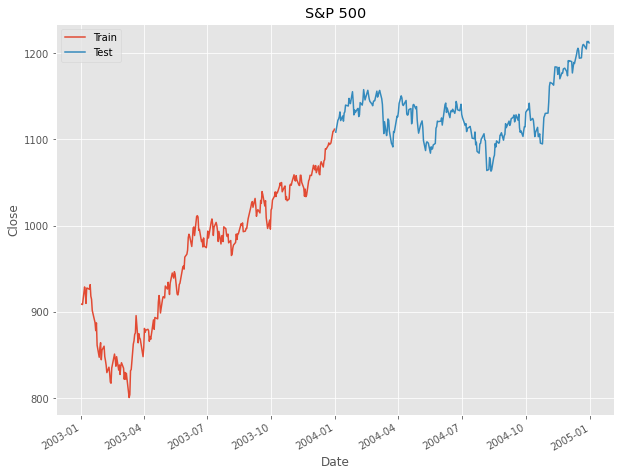

In [58]:
# yfinance package de https://pypi.org/project/yfinance/

import yfinance as yf
stock = "^GSPC"
name = "S&P 500"

train = yf.download(stock, start="2003-01-01", end="2004-01-01", progress=False)
train = train["Close"]

test = yf.download(stock, start="2004-01-01", end="2005-01-03", progress=False)
test = test["Close"]

plt.figure(figsize=(10,8))
train.plot(title=name);
test.plot(title=name);
plt.ylabel('Close');
plt.legend(['Train', 'Test']);

,Test,Éxito
0,K^2,False
1,Shapiro,False
2,Anderson-Darling,True


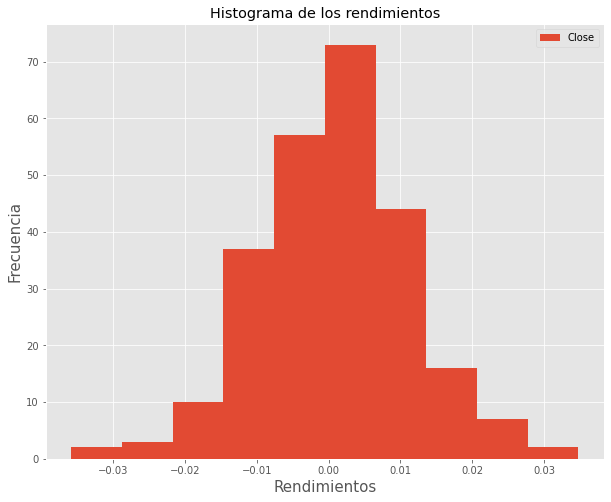

In [59]:
# Condiciones a nivel de distribución (test de normalidad)
data = pd.DataFrame(train)
rendimientos = np.log(data).diff().dropna()

_ = rendimientos.plot.hist(figsize=(10,8));
plt.title('Histograma de los rendimientos');
plt.xlabel('Rendimientos', fontsize = 15);
plt.ylabel('Frecuencia', fontsize = 15);
display(test_normalidad(rendimientos))

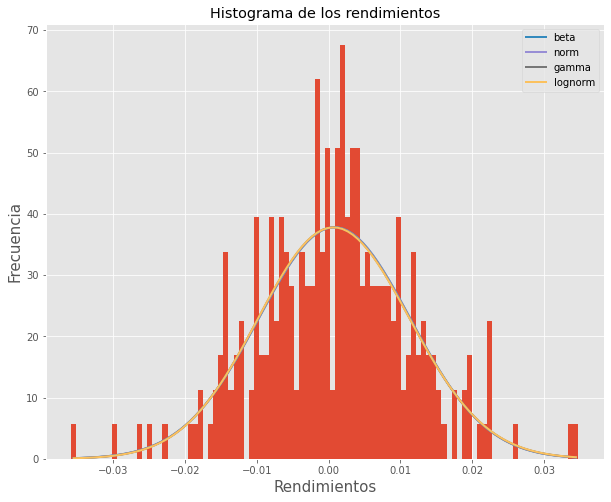

In [60]:
# Ajuste normal
plt.figure(figsize=(10,8))
f = Fitter(rendimientos, distributions=['lognorm', 'gamma', 'beta', 'norm'])
f.fit()
f.summary()
plt.title('Histograma de los rendimientos');
plt.xlabel('Rendimientos', fontsize = 15);
plt.ylabel('Frecuencia', fontsize = 15);

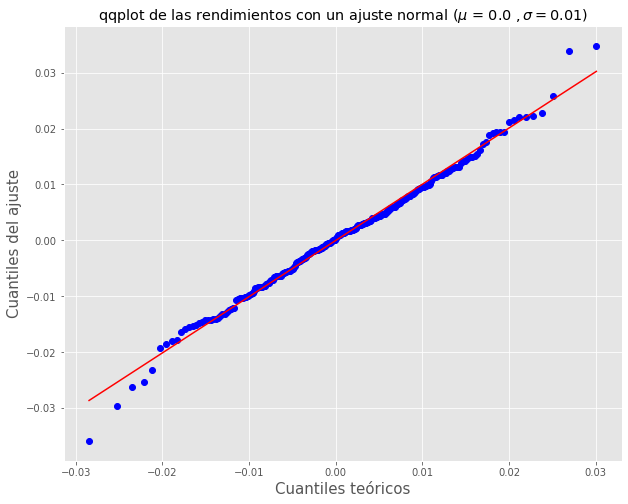

In [61]:
# QQplot respecto al ajuste normal
params = f.fitted_param["norm"]
mu_hat = round(params[0], 2)
sigma_hat = round(params[1],2)

plt.figure(figsize=(10,8))
stats.probplot(rendimientos.iloc[:,0].to_numpy(), dist=stats.norm, sparams=params, plot=pylab);

title = 'qqplot de las rendimientos con un ajuste normal ($\mu$ = ' + str(mu_hat) + ' $,\sigma = $' + str(sigma_hat) + ')'
plt.title(title);
plt.xlabel('Cuantiles teóricos', fontsize = 15);
plt.ylabel('Cuantiles del ajuste', fontsize = 15);

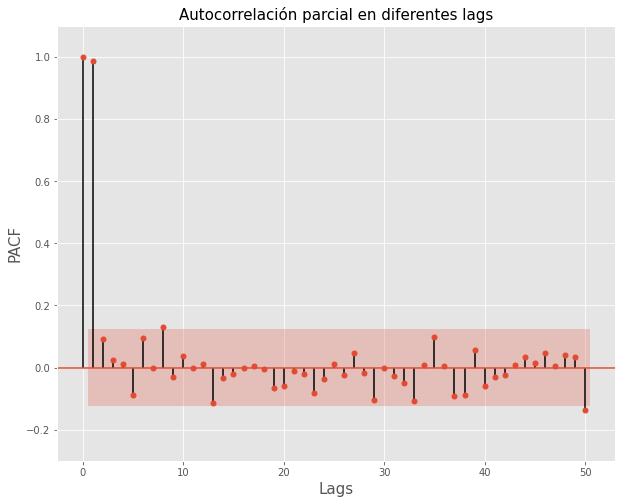

In [62]:
# Autocorrelación parcial de orden 1
fig, ax = plt.subplots(figsize=(10,8))
plot_pacf(data, ax=ax, lags=50);
plt.xlabel('Lags', fontsize = 15);
plt.ylabel('PACF', fontsize = 15);
plt.title('Autocorrelación parcial en diferentes lags', fontsize = 15);
plt.ylim([-0.3, 1.1]);

In [63]:
# Dimensión fractal (exponente de Hurst)
H, _, _ = compute_Hc(data)
D = 2-H
print('Exponente de Hurst: H = ' + str(round(H,2)))
print('Dimensión fractal:  D = ' + str(round(D,2)))

Exponente de Hurst: H = 0.64
Dimensión fractal:  D = 1.36


## 4. Estimación de parámetros

Para estimar los parámetros $\theta = [\mu, \sigma]$ se tienen los estimadores

\begin{equation}
\hat{\mu} = \frac{\bar{R_i}}{\Delta t}, \quad \hat{\sigma} = \sqrt{\frac{1}{\Delta t}\mathbb{V}[R_i]}
\end{equation}

donde $R_i$ son los rendimientos en su aproximación discreta

\begin{equation}
R_i = \frac{X(t)}{X(t-1)} - 1 = \frac{X(t)-X(t-1)}{X(t-1)}
\end{equation}

y $\bar{R_i}$ es el promedio de los rendimientos

\begin{equation}
\bar{R_i} = \sum_{t = 1}^T R_i
\end{equation}

In [64]:
num = data.diff().dropna()
den = data.iloc[:-1].set_index(num.index)
Ri = num.div(den)
Ri_bar = float(Ri.mean())

mu_hat2 = Ri_bar/dt
sigma_hat2 = np.sqrt(float(Ri.var())/dt)

display(Math(r'\hat{\mu} = ' + str(round(mu_hat2, 2))))
display(Math(r'\hat{\sigma} = ' + str(round(sigma_hat2, 2))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Entonces su solución estimada es de la forma

\begin{equation}
  \hat{X}(t) = \hat{X}(t-1) \exp\Bigg[\bigg(\hat{\mu} - \frac{1}{2}\hat{\sigma}^2\bigg)\Delta t + \hat{\sigma} \Delta B_t\Bigg], \quad \hat{X}(0) = X(0)
\end{equation}

In [65]:
# Escenario optimista
# EDEL Homogénea

l = 1000 # número de simulaciones
p = 252 # número de observaciones

X_hat1 = np.zeros((l,p))
X_hat1 = pd.DataFrame(X_hat1)

dt = 1/p # Delta de t de la solución discreta
T = np.linspace(dt, 1, p) # Intervalo equiespaciado en [0,1]
X0 = test[0] # Valor inicial
mu = 1.5*mu_hat2
sigma = sigma_hat2

for sim in range(l): # Ciclo de simulaciones
  X_hat1.iloc[sim,0] = X0
  for t in range(1, p): # Ciclo de observaciones
    dBt = np.sqrt(dt)*np.random.normal(0,1) # Delta de Bt de la sol. discreta
    # Solución discreta
    X_hat1.iloc[sim, t] = X_hat1.iloc[sim, t-1]*np.exp((mu-0.5*sigma**2)*dt + sigma*dBt)
  X_hat_serie1 = pd.Series(X_hat1.iloc[sim, :].values, index=test.index)

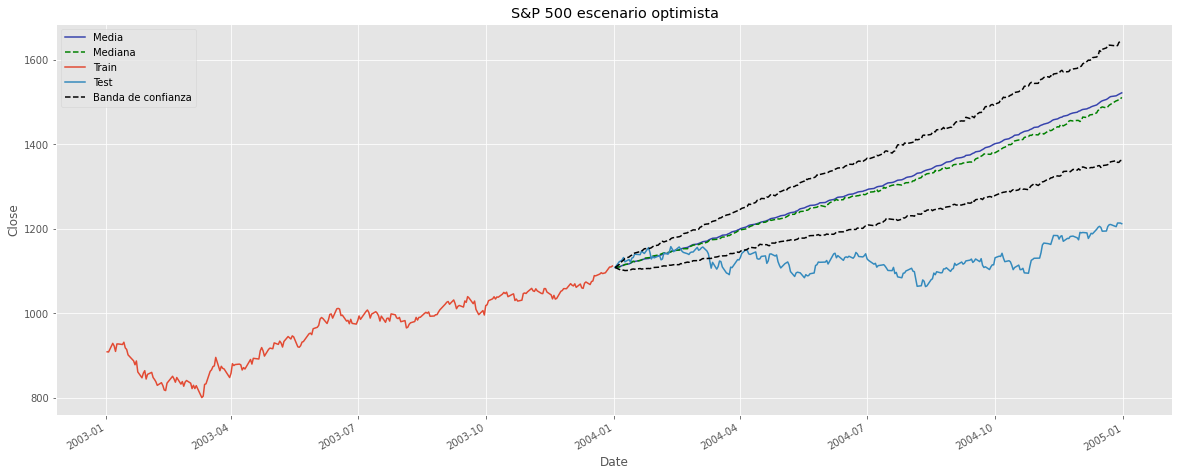

In [66]:
# Visualizar

fig1 = plt.figure(figsize=(20,8))

X_hat_mean1 = pd.Series(X_hat1.mean(axis=0).values, index=test.index)
X_hat_mean1.plot(color='#3743ad');
X_hat_median1 = pd.Series(X_hat1.quantile(q=0.5, axis=0).values, index=test.index)
X_hat_median1.plot(style='--', color='green');

train.plot()
test.plot(title= name + ' escenario optimista');

# Bandas de confianza (región 5% dentro del rango intercuartil: p30, p70)
X_hat_hi1 = pd.Series(X_hat1.quantile(q=0.70, axis=0).values, index=test.index)
X_hat_hi1.plot(style='--', color='black');
X_hat_lo1 = pd.Series(X_hat1.quantile(q=0.30, axis=0).values, index=test.index)
X_hat_lo1.plot(style='--', color='black');

plt.ylabel('Close');
plt.legend(['Media', 'Mediana', 'Train','Test', 'Banda de confianza']);

In [67]:
# Efectividad de las bandas
band_ef1 = (X_hat_lo1 <= test) & (test <= X_hat_hi1)
band_ef1 = (band_ef1.sum()/p)*100
print('Efectividad de bandas = ' + str(round(band_ef1, 2)) + ' %')

Efectividad de bandas = 16.27 %


In [68]:
# Escenario neutral
# EDEL Homogénea

l = 1000 # número de simulaciones
p = 252 # número de observaciones

X_hat2 = np.zeros((l,p))
X_hat2 = pd.DataFrame(X_hat2)

dt = 1/p # Delta de t de la solución discreta
T = np.linspace(dt, 1, p) # Intervalo equiespaciado en [0,1]
X0 = test[0] # Valor inicial
mu = mu_hat2
sigma = sigma_hat2

for sim in range(l): # Ciclo de simulaciones
  X_hat2.iloc[sim,0] = X0
  for t in range(1, p): # Ciclo de observaciones
    dBt = np.sqrt(dt)*np.random.normal(0,1) # Delta de Bt de la sol. discreta
    # Solución discreta
    X_hat2.iloc[sim, t] = X_hat2.iloc[sim, t-1]*np.exp((mu-0.5*sigma**2)*dt + sigma*dBt)
  X_hat2_serie = pd.Series(X_hat2.iloc[sim, :].values, index=test.index)

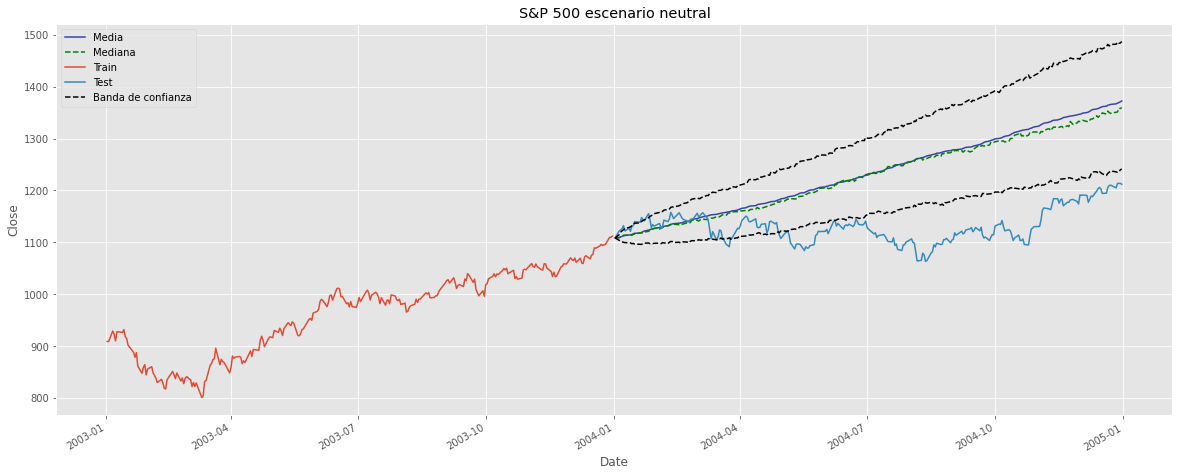

In [69]:
# Visualizar

fig2 = plt.figure(figsize=(20,8))

X_hat_mean2 = pd.Series(X_hat2.mean(axis=0).values, index=test.index)
X_hat_mean2.plot(color='#3743ad');
X_hat_median2 = pd.Series(X_hat2.quantile(q=0.5, axis=0).values, index=test.index)
X_hat_median2.plot(style='--', color='green');

train.plot()
test.plot(title= name + ' escenario neutral');

# Bandas de confianza (región 5% dentro del rango intercuartil: p30, p70)
X_hat_hi2 = pd.Series(X_hat2.quantile(q=0.70, axis=0).values, index=test.index)
X_hat_hi2.plot(style='--', color='black');
X_hat_lo2 = pd.Series(X_hat2.quantile(q=0.30, axis=0).values, index=test.index)
X_hat_lo2.plot(style='--', color='black');

plt.ylabel('Close');
plt.legend(['Media', 'Mediana', 'Train','Test', 'Banda de confianza']);

In [70]:
# Efectividad de las bandas
band_ef2 = (X_hat_lo2 <= test) & (test <= X_hat_hi2)
band_ef2 = (band_ef2.sum()/p)*100
print('Efectividad de bandas = ' + str(round(band_ef2, 2)) + ' %')

Efectividad de bandas = 27.38 %


In [71]:
# Escenario pesimista
# EDEL Homogénea

l = 1000 # número de simulaciones
p = 252 # número de observaciones

X_hat3 = np.zeros((l,p))
X_hat3 = pd.DataFrame(X_hat3)

dt = 1/p # Delta de t de la solución discreta
T = np.linspace(dt, 1, p) # Intervalo equiespaciado en [0,1]
X0 = test[0] # Valor inicial
mu = 0.5*mu_hat2
sigma = sigma_hat2

for sim in range(l): # Ciclo de simulaciones
  X_hat3.iloc[sim,0] = X0
  for t in range(1, p): # Ciclo de observaciones
    dBt = np.sqrt(dt)*np.random.normal(0,1) # Delta de Bt de la sol. discreta
    # Solución discreta
    X_hat3.iloc[sim, t] = X_hat3.iloc[sim, t-1]*np.exp((mu-0.5*sigma**2)*dt + sigma*dBt)
  X_hat3_serie = pd.Series(X_hat3.iloc[sim, :].values, index=test.index)

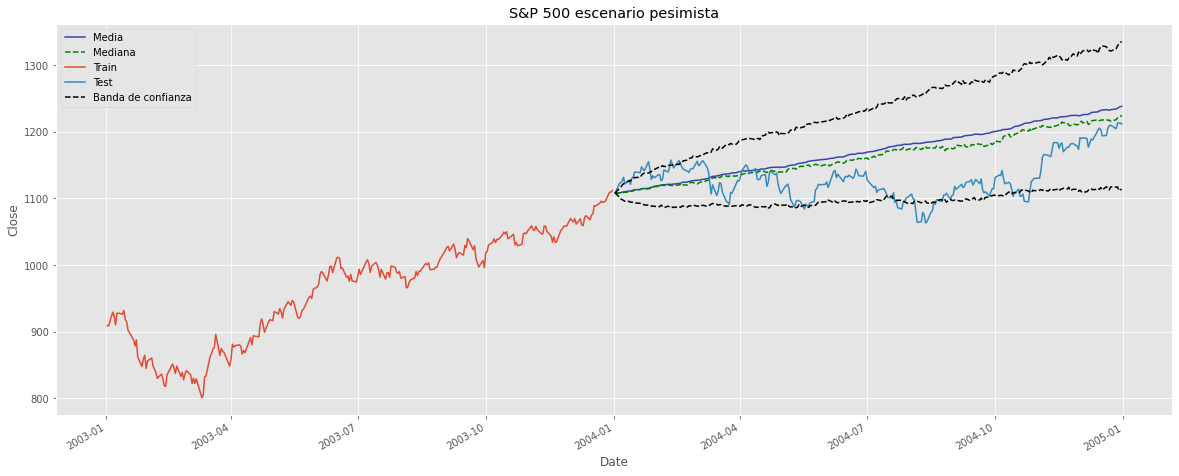

In [72]:
# Visualizar

fig3 = plt.figure(figsize=(20,8))

X_hat_mean3 = pd.Series(X_hat3.mean(axis=0).values, index=test.index)
X_hat_mean3.plot(color='#3743ad');
X_hat_median3 = pd.Series(X_hat3.quantile(q=0.5, axis=0).values, index=test.index)
X_hat_median3.plot(style='--', color='green');

train.plot()
test.plot(title= name + ' escenario pesimista');

# Bandas de confianza (región 5% dentro del rango intercuartil: p30, p70)
X_hat_hi3 = pd.Series(X_hat3.quantile(q=0.70, axis=0).values, index=test.index)
X_hat_hi3.plot(style='--', color='black');
X_hat_lo3 = pd.Series(X_hat3.quantile(q=0.30, axis=0).values, index=test.index)
X_hat_lo3.plot(style='--', color='black');

plt.ylabel('Close');
plt.legend(['Media', 'Mediana', 'Train','Test', 'Banda de confianza']);

In [73]:
# Efectividad de las bandas
band_ef3 = (X_hat_lo3 <= test) & (test <= X_hat_hi3)
band_ef3 = (band_ef3.sum()/p)*100
print('Efectividad de bandas = ' + str(round(band_ef3, 2)) + ' %')

Efectividad de bandas = 82.14 %
